# **Fazendo os imports das libs:**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string

from nltk.stem.rslp import RSLPStemmer
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /home/jv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/jv/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# **Baixando os dataframes de treino e teste:**

In [15]:
dataframe_baixado = True
try:
    df = pd.read_csv('../discurso_odio.csv')
except FileNotFoundError:
    print("Certifique-se de que o arquivo csv está na raiz do projeto.")
    dataframe_baixado = False

if (dataframe_baixado):
    print("Dataframe carregado com sucesso!")

Dataframe carregado com sucesso!


# **Visualizando os dataframes baixados:**

In [16]:
print ("Shape do dataframe de treino: ", df.shape)
df.head(10)

Shape do dataframe de treino:  (1000, 3)


,ID,text,label
0,706,Quem vive chorando são as feministas. Graças a...,0
1,887,"doida, sem amigos, mono teta, professora, corn...",1
2,439,só tem bolsominion falando mal da T.T. espumem...,0
3,705,"A bebida é um novo passaporte para o estrupo, ...",0
4,497,Eu jamais perdoaria. Eu seguiria a minha vida.,0
5,261,@NOME @NOME @NOME @NOME @NOME @NOME @NOME Entã...,0
6,222,To vendo hoje 🕷💎🤝🚀🚀🚀,0
7,527,Quando a Maria do Rosário estava protegendo um...,0
8,464,@NOME @NOME @NOME @NOME @NOME @NOME E eu sei q...,0
9,956,@NOME crista antifeminista que coisa triste,0


# **Realizando pré-processamento do texto:**

In [ ]:
# Definindo stopwords com a lib NLTK configurada para PT-BR
stop_words = list(nltk.corpus.stopwords.words('portuguese'))
                  
def pre_process_text(text: str) -> str:
    # Deixando o texto lowercase e removendo a pontuação
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    
    # Tokenização
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Inicializando o stemmer para português
    stemmer = RSLPStemmer()

    # Lematização e filtragem dos tokens:
    # 1- Aplicando a lematização
    # 2- não pode ser stopword
    # 3- ter mais de 3 caracteres (para evitar artigos, preposições e etc)
    # 4- O 1° caractere do token não pode ser número
    tokens = [ stemmer.stem(word) for word in tokens 
              if word not in stop_words
              and len(word) > 1
              and not word[0].isdigit()]
    
    # Reconstruindo texto
    return ' '.join(tokens)

# Aplicando o pré-processamento do texto no dataframe
df['text_clean'] = df['text'].apply(pre_process_text)


In [41]:
# Embaralhando o dataframe de treino
df = df.sample(frac=1, random_state=42)  

# Separando features e alvo
X = df['text']
y = df['label']

# 1ª etapa: divide o dataset em 75% treino e 25% (validação + teste)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Dimensões do conjunto de treino: {X_train.shape}")
print(f"Dimensões do conjunto de validação: {X_val.shape}")

Dimensões do conjunto de treino: (750,)
Dimensões do conjunto de validação: (250,)


In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenização
max_words = 10000  # tamanho do vocabulário
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding das sequências para um tamanho fixo
max_len = 100  # número máximo de tokens por sequência
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

print("Pré-processamento, split e tokenização concluídos!")
print("Número de palavras no vocabulário:", min(max_words, len(tokenizer.word_index)))
print("Tamanho das sequências:", X_train_pad.shape[1])

Pré-processamento, split e tokenização concluídos!
Número de palavras no vocabulário: 3709
Tamanho das sequências: 100


# **Treinamento da rede neural:**


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, F1Score 
from sklearn.utils import class_weight
import numpy as np

# Parâmetros
embedding_dim = 128   # dimensão dos vetores de embedding
max_len = X_train_pad.shape[1]
vocab_size = min(10000, len(tokenizer.word_index) + 1)

# Definindo a RNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(64, return_sequences=False))  
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilação
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        Precision(name='precision'), 
        Recall(name='recall'),
        F1Score(name='f1_score') 
    ]
)

# Treinamento
history = model.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
)

/home/jv/Documentos/GitHub/Projetos-Topicos-Avancados-em-IA/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.7800 - f1_score: 0.3589 - loss: 0.5548 - precision: 0.3333 - recall: 0.0061 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss: 0.5294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7813 - f1_score: 0.3589 - loss: 0.5315 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss: 0.5242 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7840 - f1_score: 0.3589 - loss: 0.5344 - precision: 1.0000 - recall: 0.0122 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss: 0.5224 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7853 - f1_score: 0.3589 - loss: 0.5357 - precision: 1.0000 - recall: 0.0183 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss: 0.5218 - val_pre

# **Plotando a acurácia do modelo em gráfico:**

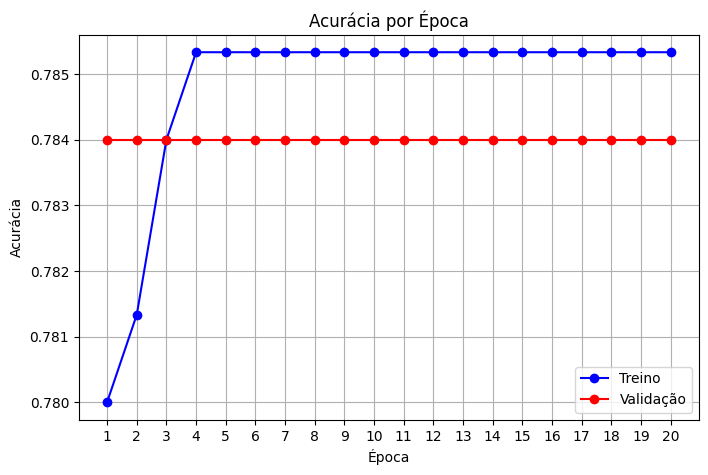

In [45]:
# Acurácia por época
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

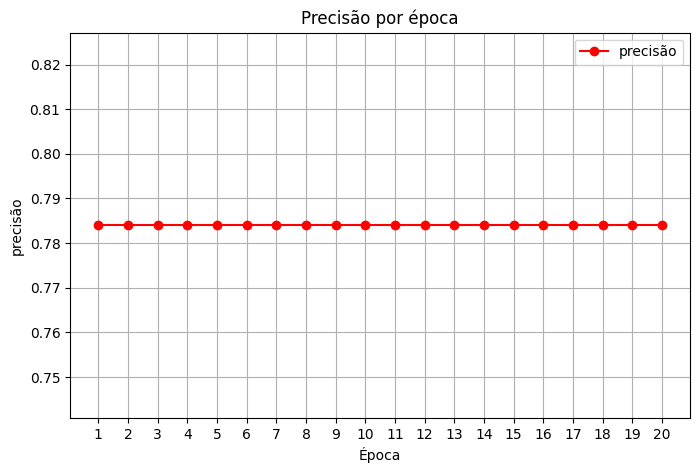

In [46]:
# Acurácia por época
acc = history.history['precision']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, val_acc, 'ro-', label='precisão')
plt.title('Precisão por época')
plt.xlabel('Época')
plt.ylabel('precisão')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

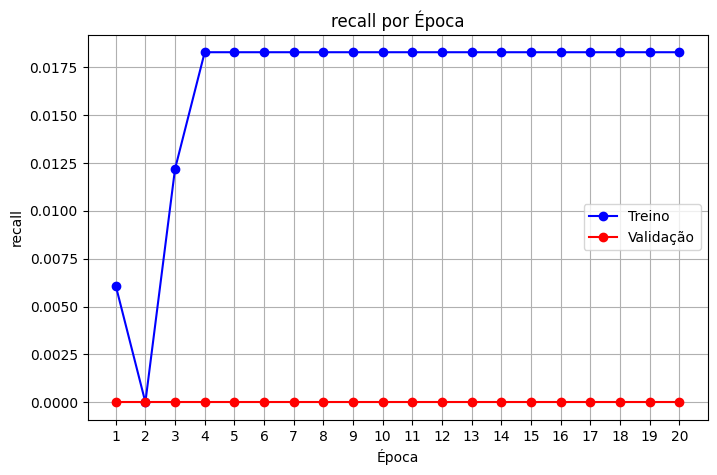

In [47]:
# Acurácia por época
acc = history.history['recall']
val_acc = history.history['val_recall']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('recall por Época')
plt.xlabel('Época')
plt.ylabel('recall')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


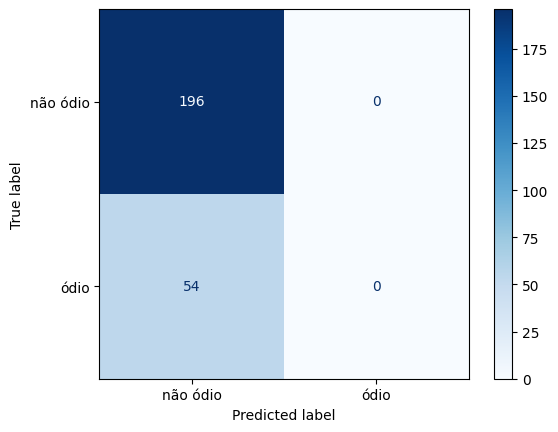

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazendo predições no conjunto de validação
y_pred_probs = model.predict(X_val_pad)

# Convertendo probabilidades para classes (0 ou 1)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Plotando a matriz de confusão
cm = confusion_matrix(y_val, y_pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["não ódio", "ódio"])
disp.plot(cmap="Blues")
plt.show()

# **Modelo bidirecional + camada de atenção**

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import EarlyStopping

# Parâmetros
embedding_dim = 128
max_len = X_train_pad.shape[1]
vocab_size = min(10000, len(tokenizer.word_index) + 1)

# Definindo a RNN com Camada de Atenção
inputs = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
# A camada LSTM deve retornar sequências completas para que a camada de atenção possa processá-las
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)

# Camada de Atenção
attention_out = Attention()([lstm_out, lstm_out])

# Combinar a saída da atenção para criar um único vetor de contexto para toda a frase
context_vector = GlobalAveragePooling1D()(attention_out)

# Adicionar a camada de Dropout e a camada de saída
x = Dropout(0.5)(context_vector)
outputs = Dense(1, activation='sigmoid')(x)

# Criar o modelo
model_attention = Model(inputs=inputs, outputs=outputs)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) 

# Compilação
model_attention.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score') 
    ]
)

# Treinamento
history_attention = model_attention.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad,  y_val),
    callbacks=[early_stopping]
)

/home/jv/Documentos/GitHub/Projetos-Topicos-Avancados-em-IA/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.7627 - f1_score: 0.3589 - loss: 0.5553 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss: 0.5352 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7813 - f1_score: 0.3589 - loss: 0.5337 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss: 0.5265 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.7813 - f1_score: 0.3589 - loss: 0.5314 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss: 0.5291 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7813 - f1_score: 0.3589 - loss: 0.5319 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7840 - val_f1_score: 0.3553 - val_loss:

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


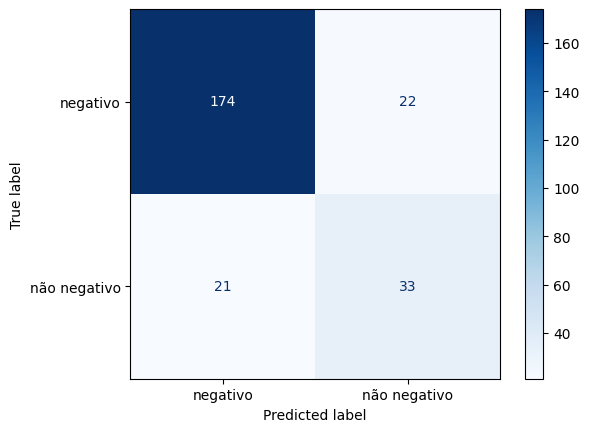

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazendo predições no conjunto de validação
y_pred_probs = model_attention.predict(X_val_pad)

# Convertendo probabilidades para classes (0 ou 1)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Plotando a matriz de confusão
cm = confusion_matrix(y_val, y_pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negativo", "não negativo"])
disp.plot(cmap="Blues")
plt.show()

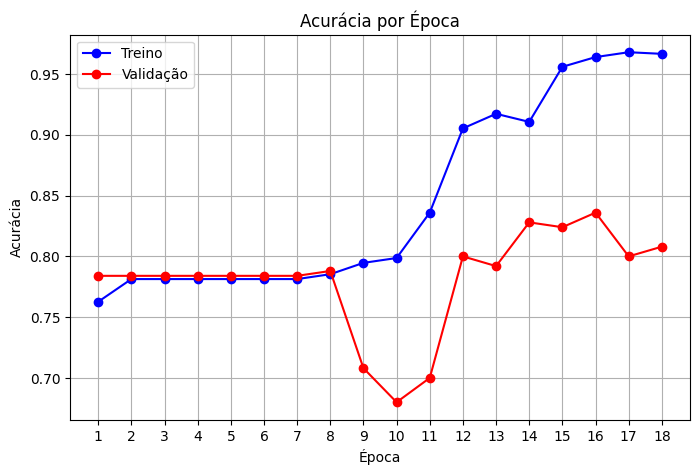

In [70]:
# Acurácia por época
acc = history_attention.history['accuracy']
val_acc = history_attention.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

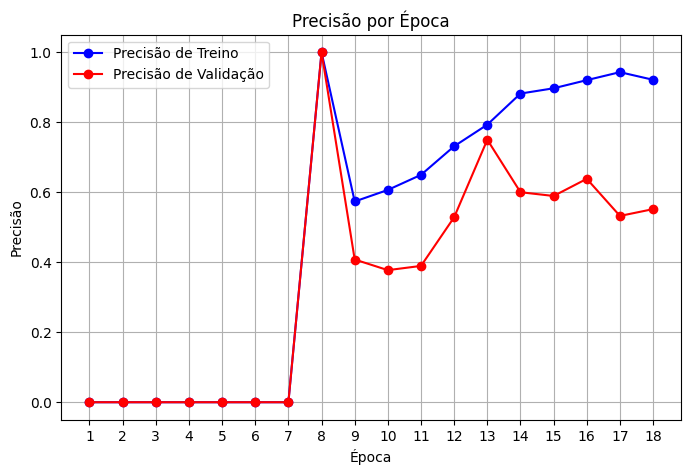

In [73]:

# Extrair os dados de precisão do histórico
precision_treino = history_attention.history['precision']
precision_validacao = history_attention.history['val_precision']
epochs = range(1, len(precision_treino) + 1)

# Plotar a precisão
plt.figure(figsize=(8, 5))
plt.plot(epochs, precision_treino, 'bo-', label='Precisão de Treino')
plt.plot(epochs, precision_validacao, 'ro-', label='Precisão de Validação')
plt.title('Precisão por Época')
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()